# 2 body problem draft

This notebook was adapted from `Orbit_eq_with_different_algorithims.ipynb`.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

In [3]:
class GravitationalOrbits:
    """
    This class implements the parameters and equations for solving two body graviatational orbits from Lagrange's 
    euqauations
    m1 float:
    the mass of object 1
    m2 float:
    the mass of object 2
    G float:
    the gravitational constant
    """
    
    def __init__(self, m1 = 1., m2 = 1., G=1.):
        self.m1 = m1
        self.m2 = m2
        self.G = G
     
    def dz_dt(self, t, z):
        """
        This function returns the right-hand side of the diffeq: 
        
        
        Parameters
        ----------
        t : float
            time 
        z : float
            8-component vector with:
            z[0] = x1(t), z[1] = dx1/dt,
            z[2] = y1(t), z[3] = dy1/dt,
            z[4] = x2(t), z[5] = dx2/dt,
            z[6] = y2(t), z[7] = dy2/dt
            
        """
        r_12 = np.sqrt((z[0] - z[4])**2 + (z[6] - z[2])**2)
        return [ \
                z[1], self.G * self.m2 * (z[4] - z[0])/r_12**3 , \
                z[3], self.G * self.m2 * (z[6] - z[2])/r_12**3 , \
                z[5], -self.G * self.m1 * (z[4] - z[0])/r_12**3 , \
                z[7], -self.G * self.m1 * (z[6] - z[2])/r_12**3 , \
                 ]
    
    
    def solve_ode(self, t_pts, z_0,
                  method='RK23',
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        Use solve_ivp with the option of specifying the method.
        Specify smaller abserr and relerr to get more precision.
        """
         
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]), 
                             z_0, t_eval=t_pts, method=method, 
                             atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot  = solution.y
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
    
   
    
    def solve_ode_Leapfrog(self, t_pts, z_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        
        x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0 = z_0
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        
        x1 = np.zeros(num_t_pts)
        x1_dot = np.zeros(num_t_pts)
        x1_dot_half = np.zeros(num_t_pts)
        
        y1 = np.zeros(num_t_pts)
        y1_dot = np.zeros(num_t_pts)
        y1_dot_half = np.zeros(num_t_pts)
        
        x2 = np.zeros(num_t_pts)
        x2_dot = np.zeros(num_t_pts)
        x2_dot_half = np.zeros(num_t_pts)
        
        y2 = np.zeros(num_t_pts)
        y2_dot = np.zeros(num_t_pts)
        y2_dot_half = np.zeros(num_t_pts)
        
        
        # initial conditions
        x1[0] = x1_0
        x1_dot[0] = x1_dot_0
        
        y1[0] = y1_0
        y1_dot[0] = y1_dot_0
        
        x2[0] = x2_0
        x2_dot[0] = x2_dot_0
        
        y2[0] = y2_0
        y2_dot[0] = y2_dot_0
        
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            z = [x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot]
            out = self.dz_dt(t, z)
            
            x1_dot_half[i] = x1_dot[i] + out[1] * delta_t/2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            
            y1_dot_half[i] = y1_dot[i] + out[3] * delta_t/2.
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            
            x2_dot_half[i] = x2_dot[i] + out[5] * delta_t/2.
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            
            y2_dot_half[i] = y2_dot[i] + out[7] * delta_t/2.
            y2[i+1] = y2[i] + y2_dot_half[i] * delta_t
            
            z = [x1[i+1], x1_dot[i], y1[i+1], y1_dot[i], \
                 x2[i+1], x2_dot[i], y2[i+1], y2_dot[i]]
            out = self.dz_dt(t, z)
            
            x1_dot[i+1] = x1_dot_half[i] + out[1] * delta_t/2.
            y1_dot[i+1] = y1_dot_half[i] + out[3] * delta_t/2.
            x2_dot[i+1] = x2_dot_half[i] + out[5] * delta_t/2.
            y2_dot[i+1] = y2_dot_half[i] + out[7] * delta_t/2.
            
            
            
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot  
        
    
    

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

# Find two Body Orbits

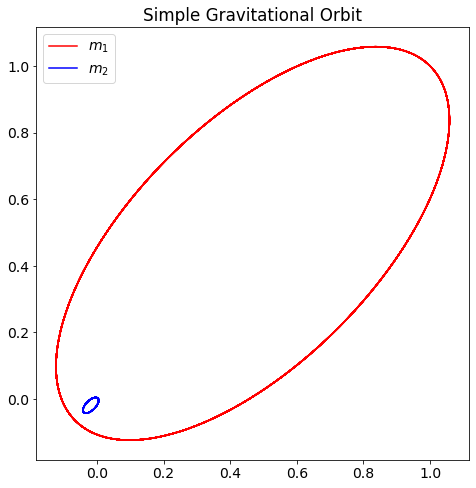

In [16]:
#orbit labels
orbit_labels = (r'$x$', r'$y$')

# Plotting time 
t_start = 0.
t_end = 10.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G= 1.
m1= 1.
m2 = 25.

o1 = GravitationalOrbits(m1, m2, G)

# Initial conditions
x1_0, x1_dot_0 = 1. , -1.
y1_0, y1_dot_0 = 1. , 1.
x2_0, x2_dot_0 = - (m1/m2) * x1_0, - (m1/m2) * x1_dot_0
y2_0, y2_dot_0 = - (m1/m2) * y1_0, - (m1/m2) * y1_dot_0

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o1.solve_ode(t_pts, z_0)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end) 
ax.plot(x1, y1, color = 'red', label= r'$m_1$')
ax.plot(x2, y2, color = 'blue', label= r'$m_2$')
ax.set_title('Simple Gravitational Orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()